## Постановка задачи

### MRR
Исходные данные - результат `generate_subsample` 

**Задача** - по аналогии с precision написать три версии функции подсчета Mean Reciprocal Rank (naive, numba, pandas) и протестировать на разных размерах выборки
- **Протестируйте** для всех комбинаций (users_count, top_k):
  - users_count - [100, 1000, 10000, 100000]
  - top_k - [10, 50, 100]
- Результатом тестирования должен быть **график**, где будут отражены следующие показатели:
  - Алгоритм - naive, numba, pandas
  - Скорость работы (время)
  - users_count
  - top_k

## Импорты

In [ ]:
try:
    import rectools
except:
    !pip install rectools
    import rectools

In [ ]:
import timeit
from tqdm.auto import tqdm

import numpy as np
import numba as nb
import pandas as pd
from matplotlib import pyplot as plt

import requests

from rectools import Columns

## Подготовка данных

### Загрузка

In [ ]:
!mkdir -p ../data/hw2-3/

In [ ]:
url = "https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip"

In [ ]:
req = requests.get(url, stream=True)

with open("../data/hw2-3/kion.zip", "wb") as fd:
    total_size_in_bytes = int(req.headers.get("Content-Length", 0))
    progress_bar = tqdm(
        desc="kion dataset download",
        total=total_size_in_bytes,
        unit="iB",
        unit_scale=True,
    )
    for chunk in req.iter_content(chunk_size=2**20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [ ]:
!unzip ../data/hw2-3/kion.zip -d ../data/hw2-3/

Archive:  ../data/hw2-3/kion.zip
replace ../data/hw2-3/data_original/interactions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ../data/hw2-3/data_original/interactions.csv  
  inflating: ../data/hw2-3/__MACOSX/data_original/._interactions.csv  
  inflating: ../data/hw2-3/data_original/users.csv  
  inflating: ../data/hw2-3/__MACOSX/data_original/._users.csv  
  inflating: ../data/hw2-3/data_original/items.csv  
  inflating: ../data/hw2-3/__MACOSX/data_original/._items.csv  


### Препроцессинг

In [ ]:
interactions = pd.read_csv("../data/hw2-3/data_original/interactions.csv")

interactions.rename(
    columns={
        "track_id": Columns.Item,
        "last_watch_dt": Columns.Datetime,
        "total_dur": Columns.Weight,
    },
    inplace=True,
)

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])

In [ ]:
users = pd.read_csv("../data/hw2-3/data_original/users.csv")
items = pd.read_csv("../data/hw2-3/data_original/items.csv")

In [ ]:
def headtail(df):
    return pd.concat([df.head(), df.tail()])


headtail(interactions)

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [ ]:
def generate_subsample(users_count, top_k):
    users = np.random.choice(
        interactions[Columns.User].unique(), users_count, replace=False
    )
    df = interactions[interactions[Columns.User].isin(users)].reset_index(drop=True)
    del df[Columns.Datetime], df[Columns.Weight], df["watched_pct"]

    recs = np.random.choice(df[Columns.Item], size=(users_count, top_k))
    return df, users, recs

## Реализация

## Naive

In [ ]:
def mrr_naive(target, users, recs):
    mrr = []
    for i, user in enumerate(users):
        user_mrr = 0
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                user_mrr = 1 / (j + 1)
                break
        mrr.append(user_mrr)
    return sum(mrr) / len(mrr)

### Numba

In [ ]:
@nb.njit(cache=True, parallel=True)
def mrr_numba(target, users, recs):
    mrr = np.zeros(len(users))
    for i in nb.prange(len(users)):
        user = users[i]
        user_mrr = 0
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                user_mrr = 1 / (j + 1)
                break
        mrr[i] = user_mrr
    return mrr.mean()

## Pandas

In [ ]:
def mrr_pandas(df, users, recs):
    k = recs.shape[1]
    df_recs = pd.DataFrame(
        {Columns.User: np.repeat(users, k), Columns.Item: recs.ravel()}
    )
    df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1
    df_recs = df.merge(
        df_recs,
        how="left",
        left_on=[Columns.User, Columns.Item],
        right_on=[Columns.User, Columns.Item],
    )
    # Получение минимального ранга для каждого item'a для каждого user'а
    min_rank = df_recs.groupby([Columns.User, Columns.Item])["rank"].min()
    # Получение минимального ранга для каждого user'а
    min_rank = min_rank.reset_index().groupby(Columns.User).min()
    # Нахождение обратного ранга
    reciprocal_rank = 1 / min_rank["rank"]
    # Подсчет среднего значения
    mrr = reciprocal_rank.sum() / len(users)
    return mrr

## Тестирование корректности результатов

In [ ]:
n_runs = 2
top_k = [10, 50, 100]
users_count = [100, 1000, 10000]

In [ ]:
for user_count in users_count:
    for k in top_k:
        for _ in range(n_runs):
            df, users, recs = generate_subsample(user_count, k)
            mrr1 = mrr_pandas(df, users, recs)
            mrr2 = mrr_naive(df.values, users, recs)
            mrr3 = mrr_numba(df.values, users, recs)

            assert np.abs(mrr1 - mrr2).sum() < 1e-8, "Pandas != Native"
            assert np.abs(mrr1 - mrr3).sum() < 1e-8, "Pandas != Numba"
            assert np.abs(mrr3 - mrr2).sum() < 1e-8, "Numba != Native"
print("Accepted!")

Accepted!


## Тестирование времени работы

In [ ]:
n_runs = 2
top_k = [10, 50, 100]
users_count = [100, 1000, 10000]

In [ ]:
methods = {
    "Naive": "mrr_naive(df.values, users, recs)",
    "Numba": "mrr_numba(df.values, users, recs)",
    "Pandas": "mrr_pandas(df, users, recs)",
}

In [ ]:
result = {}
for name in methods:
    result[name] = np.zeros((len(users_count), len(top_k)))

In [ ]:
for i, user_count in enumerate(users_count):
    for j, k in enumerate(top_k):
        df, users, recs = generate_subsample(user_count, k)
        for name in methods:
            print(f"Run methods: {name}, user_count: {user_count}, k: {k}")
            t = timeit.repeat(
                methods[name],
                "from __main__ import mrr_naive, mrr_numba, mrr_pandas, df, users, recs",
                repeat=n_runs,
                number=n_runs,
            )
            print(f"Time: {sum(t) / len(t)}")
            result[name][i][j] = sum(t) / len(t)

Run methods: Naive, user_count: 100, k: 10
Time: 0.014995814000030805
Run methods: Numba, user_count: 100, k: 10
Time: 0.000988642500487913
Run methods: Pandas, user_count: 100, k: 10
Time: 0.01771497099980479
Run methods: Naive, user_count: 100, k: 50
Time: 0.02777476050050609
Run methods: Numba, user_count: 100, k: 50
Time: 0.001610690499546763
Run methods: Pandas, user_count: 100, k: 50
Time: 0.01875138500054163
Run methods: Naive, user_count: 100, k: 100
Time: 0.041064652999921236
Run methods: Numba, user_count: 100, k: 100
Time: 0.0008661520005261991
Run methods: Pandas, user_count: 100, k: 100
Time: 0.020493632499892556
Run methods: Naive, user_count: 1000, k: 10
Time: 0.1319106285009184
Run methods: Numba, user_count: 1000, k: 10
Time: 0.02238799799943081
Run methods: Pandas, user_count: 1000, k: 10
Time: 0.02630737450090237
Run methods: Naive, user_count: 1000, k: 50
Time: 0.2855684004989598
Run methods: Numba, user_count: 1000, k: 50
Time: 0.03260876600052143
Run methods: Pand

### Plot graph

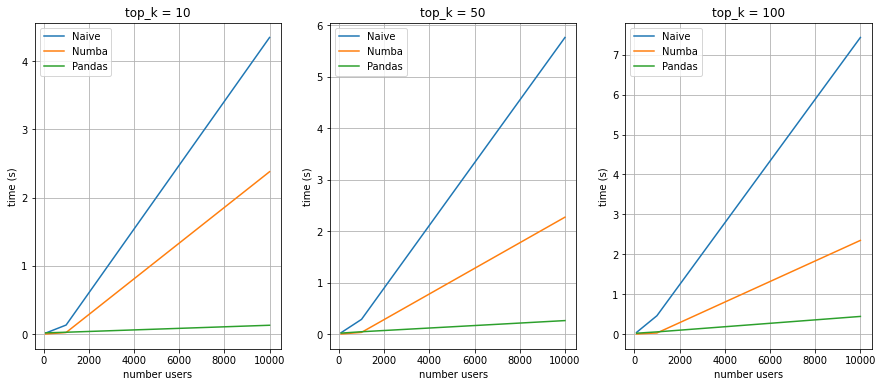

In [ ]:
_, ax = plt.subplots(1, 3, figsize=(15, 6))

for i in range(len(top_k)):
    for j, name in enumerate(methods):
        ax[i].plot(users_count, result[name][:, i], label=name)
    ax[i].set_title(f"top_k = {top_k[i]}")
    ax[i].set_xlabel("number users")
    ax[i].set_ylabel("time (s)")
    ax[i].grid()
    ax[i].legend()

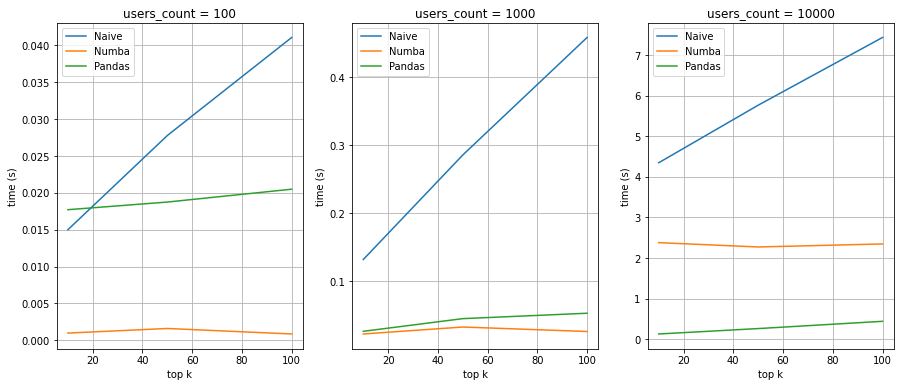

In [ ]:
_, ax = plt.subplots(1, 3, figsize=(15, 6))
for i in range(len(users_count)):
    for j, name in enumerate(methods):
        ax[i].plot(top_k, result[name][i, :], label=name)
    ax[i].set_title(f"users_count = {users_count[i]}")
    ax[i].set_xlabel("top k")
    ax[i].set_ylabel("time (s)")
    ax[i].grid()
    ax[i].legend()